In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


# Device configuration
device = torch.device( 'cuda'  if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 2
batch_size = 4
learning_rate = 0.001

In [2]:

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='.\data', transform=transform,
                                             train=True, download=True)

test_dataset = torchvision.datasets.CIFAR10(root='.\data', transform=transform,
                                            train=False)

train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True)


Files already downloaded and verified


In [3]:

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

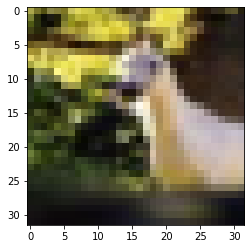

In [4]:
# get some random training images
dataiter  = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [5]:

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cnn1 = nn.Conv2d(3,6,5)
        self.pooling = nn.MaxPool2d(2,2)
        self.cnn2 = nn.Conv2d(6,16,5)

        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)


    def forward(self, x):
         # -> n, 3, 32, 32
         def __init__(self):
             super(ConvNet, self).__init__()
             x = self.pooling(F.relu(self.cnn1(x)))     # -> n, 6, 14, 14
             x = self.pooling(F.relu(self.cnn2(x)))# -> n, 16, 5, 5
             x =x.view(-1, 16*5*5) # -> n, 400
             x = self.fc1(x) # -> n, 120
             x = self.fc2(x) # -> n, 84
             x = self.fc3(x) # -> n, 10
             return x




### Training Loop

In [8]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [2000/12500], Loss: 2.3117
Epoch [1/5], Step [4000/12500], Loss: 2.2796
Epoch [1/5], Step [6000/12500], Loss: 2.3105
Epoch [1/5], Step [8000/12500], Loss: 2.3061
Epoch [1/5], Step [10000/12500], Loss: 2.3034
Epoch [1/5], Step [12000/12500], Loss: 2.1105
Epoch [2/5], Step [2000/12500], Loss: 1.8461
Epoch [2/5], Step [4000/12500], Loss: 1.8025
Epoch [2/5], Step [6000/12500], Loss: 1.4768
Epoch [2/5], Step [8000/12500], Loss: 2.1638
Epoch [2/5], Step [10000/12500], Loss: 1.9670
Epoch [2/5], Step [12000/12500], Loss: 1.6845
Epoch [3/5], Step [2000/12500], Loss: 1.7840
Epoch [3/5], Step [4000/12500], Loss: 2.3478
Epoch [3/5], Step [6000/12500], Loss: 1.3317
Epoch [3/5], Step [8000/12500], Loss: 1.2677
Epoch [3/5], Step [10000/12500], Loss: 1.1060
Epoch [3/5], Step [12000/12500], Loss: 0.9136
Epoch [4/5], Step [2000/12500], Loss: 1.2148
Epoch [4/5], Step [4000/12500], Loss: 1.0387
Epoch [4/5], Step [6000/12500], Loss: 1.3851
Epoch [4/5], Step [8000/12500], Loss: 1.2583
Epoc

In [9]:
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')


Finished Training
Accuracy of the network: 49.37 %
Accuracy of plane: 60.4 %
Accuracy of car: 77.1 %
Accuracy of bird: 34.5 %
Accuracy of cat: 22.2 %
Accuracy of deer: 30.4 %
Accuracy of dog: 37.8 %
Accuracy of frog: 66.7 %
Accuracy of horse: 62.1 %
Accuracy of ship: 56.0 %
Accuracy of truck: 46.5 %
